In [14]:
import numpy as np
from PIL import Image as PILImage
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create frames directory if it doesn't exist
try:
    os.mkdir('frames')
except FileExistsError:
    pass

# Read the data
df = pd.read_csv('combined_results.csv')

# Create list to store frame images
frame_images = []

# Set up colors
colors = plt.cm.viridis(np.linspace(0, 1, 2))

# Create figure that will be reused for each frame
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)

# Initialize empty lists to store all run data
all_target_pitches = []
all_measured_pitches = []
run_boundaries = [0]  # Keep track of where each run starts

# First collect all valid run data
for run in range(1, 55):
    pitch_col = f'pitch_{run}'
    measured_pitch_col = f'measured_pitch_{run}'
    
    if pitch_col in df.columns and measured_pitch_col in df.columns:
        # Get non-null values only
        valid_data = df[df[pitch_col].notna() & df[measured_pitch_col].notna()]
        if not valid_data.empty:
            all_target_pitches.extend(valid_data[pitch_col])
            all_measured_pitches.extend(valid_data[measured_pitch_col])
            run_boundaries.append(len(all_target_pitches))

# Now create frames point by point
for i in range(len(all_target_pitches)):
    ax.clear()
    
    # Find current run index
    current_run = next(j for j, boundary in enumerate(run_boundaries) if boundary > i) 
    points_in_current_run = i - run_boundaries[current_run-1]
    
    # Plot data up to current point
    ax.plot(range(points_in_current_run + 1), 
            all_target_pitches[run_boundaries[current_run-1]:i+1],
            label='Target Pitch', color=colors[0], alpha=0.8)
    ax.plot(range(points_in_current_run + 1), 
            all_measured_pitches[run_boundaries[current_run-1]:i+1],
            label='Measured Pitch', color=colors[1], alpha=0.8)
    
    ax.set_xlabel('Time (samples)')
    ax.set_ylabel('Pitch (degrees)')
    ax.set_title(f'Target vs Measured Pitch Over Time (Run {current_run})')
    ax.legend()
    ax.grid(True)
    
    # Set consistent axis limits for current run
    run_target = all_target_pitches[run_boundaries[current_run-1]:run_boundaries[current_run]]
    run_measured = all_measured_pitches[run_boundaries[current_run-1]:run_boundaries[current_run]]
    ax.set_ylim(min(min(run_target), min(run_measured)),
                max(max(run_target), max(run_measured)))
    ax.set_xlim(0, len(run_target))
    
    # Save frame
    frame_filename = os.path.join('frames', f"pitch_frame_{i:04d}.png")
    plt.savefig(frame_filename)
    frame_images.append(PILImage.open(frame_filename))

# Save animation as GIF
frame_images[0].save(
    'pitch_animation.gif',
    save_all=True,
    append_images=frame_images[1:],
    duration=25,
    loop=0
)

plt.close()


In [23]:
import numpy as np
from PIL import Image as PILImage
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil

# Clear frames directory if it exists and recreate it
if os.path.exists('frames4'):
    shutil.rmtree('frames4')
os.mkdir('frames4')

# Read the data
df = pd.read_csv('combined_results.csv')

# Create list to store frame images
frame_images = []

# Set up colors
colors = plt.cm.viridis(np.linspace(0, 1, 55))  # More colors for multiple runs

# Create figure that will be reused for each frame
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111)

# Initialize empty lists to store all run data
all_target_pitches = []
all_measured_pitches = []
run_boundaries = [0]  # Keep track of where each run starts
valid_runs = []  # Keep track of valid run numbers
max_run_length = 0  # Track the longest run

# First collect all valid run data
for run in range(1, 55):
    pitch_col = f'pitch_{run}'
    measured_pitch_col = f'measured_pitch_{run}'
    
    if pitch_col in df.columns and measured_pitch_col in df.columns:
        # Get non-null values only
        valid_data = df[df[pitch_col].notna() & df[measured_pitch_col].notna()]
        if not valid_data.empty:
            run_length = len(valid_data)
            max_run_length = max(max_run_length, run_length)
            all_target_pitches.extend(valid_data[pitch_col].values)
            all_measured_pitches.extend(valid_data[measured_pitch_col].values)
            run_boundaries.append(len(all_target_pitches))
            valid_runs.append(run)

# Now create frames point by point
for i in range(len(all_target_pitches)):
    ax.clear()
    
    # Find current run index and position within run
    current_run = next(j for j, boundary in enumerate(run_boundaries) if boundary > i)
    start_idx = run_boundaries[current_run-1]
    points_in_current_run = i - start_idx
    
    # Plot each completed run
    for run_idx in range(current_run-1):
        run_start = run_boundaries[run_idx]
        run_end = run_boundaries[run_idx+1]
        x_values = range(run_end - run_start)
        ax.plot(x_values, all_target_pitches[run_start:run_end],
                label='Target Pitch' if run_idx == 0 else None, 
                color='blue', alpha=0.8, linestyle='-')
        ax.plot(x_values, all_measured_pitches[run_start:run_end],
                label='Measured Pitch' if run_idx == 0 else None, 
                color='red', alpha=0.8, linestyle='--')
    
    # Plot current run up to current point
    x_values = range(points_in_current_run + 1)
    ax.plot(x_values, all_target_pitches[start_idx:i+1],
            color='blue', alpha=0.8, linestyle='-')
    ax.plot(x_values, all_measured_pitches[start_idx:i+1],
            color='red', alpha=0.8, linestyle='--')
    
    ax.set_xlabel('Time (samples)')
    ax.set_ylabel('Pitch (degrees)')
    ax.set_title('Target vs Measured Pitch Over Time (All Runs)')
    ax.legend()
    ax.grid(True)
    
    # Set axis limits
    ax.set_ylim(min(min(all_target_pitches), min(all_measured_pitches)),
                max(max(all_target_pitches), max(all_measured_pitches)))
    ax.set_xlim(0, max_run_length)
    
    # Save frame
    frame_filename = os.path.join('frames4', f"multi_pitch_frame_{i:04d}.png")
    plt.savefig(frame_filename, bbox_inches='tight')
    frame_images.append(PILImage.open(frame_filename))

# Save animation as GIF
frame_images[0].save(
    'multi_pitch_animation4.gif',
    save_all=True,
    append_images=frame_images[1:],
    duration=25,  # Faster animation since there are more frames
    loop=0
)

plt.close()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

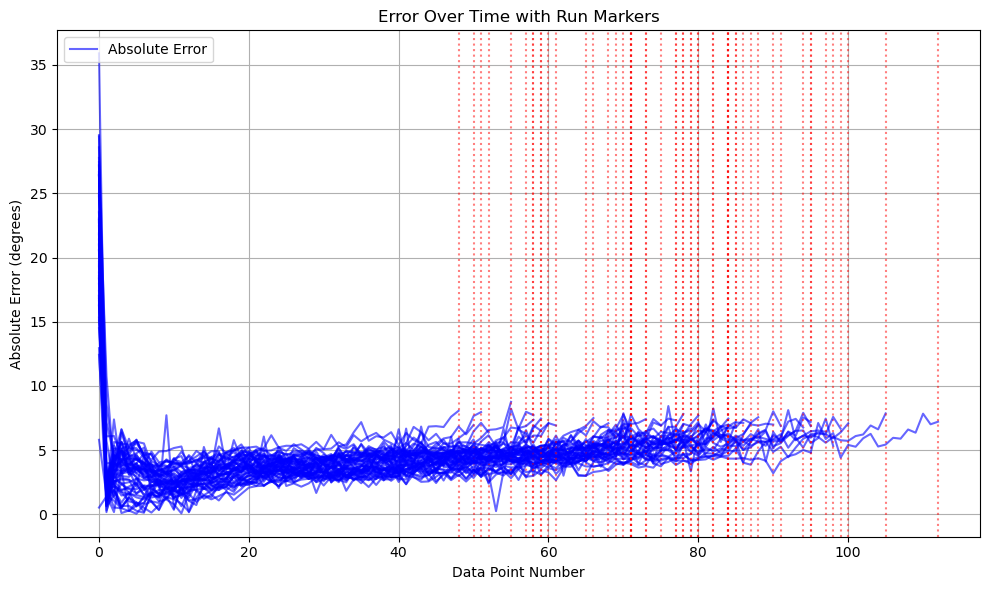

In [10]:
# Create new figure for error plot
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot error data from all runs
for run in range(1, 55):
    error_col = f'err_{run}'
    if error_col in df.columns:
        # Get non-null values only
        valid_data = df[df[error_col].notna()]
        if not valid_data.empty:
            # Create index array starting from 0 for x-axis
            x_indices = range(len(valid_data))
            ax.plot(x_indices, valid_data[error_col], 
                    color='blue', alpha=0.6, 
                    label='Absolute Error' if run == 1 else None)
            
            # Add vertical line at the last valid index for this run
            last_idx = len(valid_data) - 1
            ax.axvline(x=last_idx, color='red', linestyle=':', alpha=0.5)
    
ax.set_xlabel('Data Point Number')
ax.set_ylabel('Absolute Error (degrees)')
ax.set_title('Error Over Time with Run Markers')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


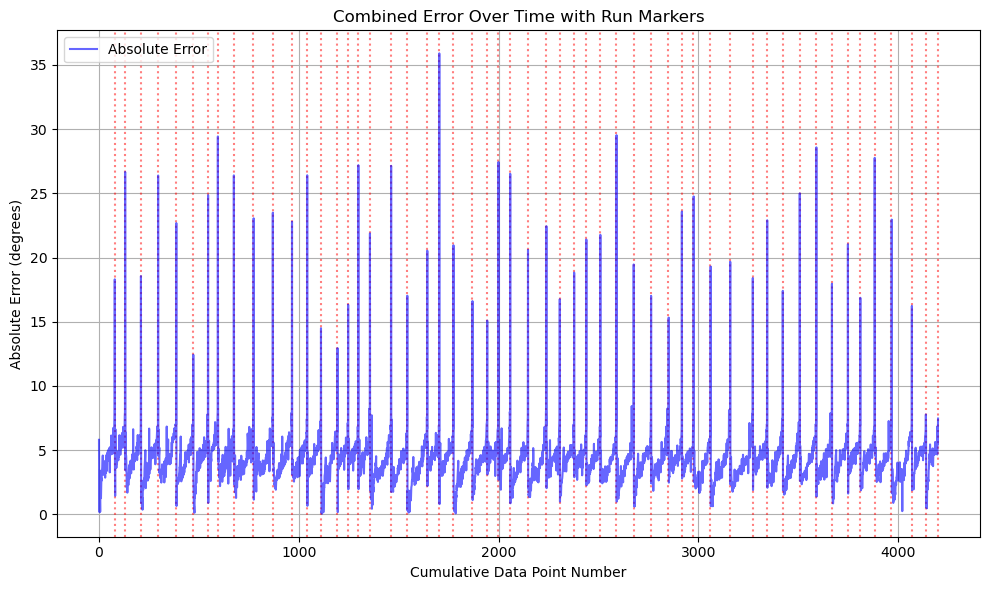

In [11]:
# Create new figure for error plot
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Combine all error data into one continuous series
all_errors = []
all_indices = []
current_index = 0

for run in range(1, 55):
    error_col = f'err_{run}'
    if error_col in df.columns:
        # Get non-null values only
        valid_data = df[df[error_col].notna()]
        if not valid_data.empty:
            # Add errors to combined list
            errors = valid_data[error_col].tolist()
            all_errors.extend(errors)
            
            # Create continuous indices
            indices = range(current_index, current_index + len(errors))
            all_indices.extend(indices)
            
            # Update current index
            current_index += len(errors)
            
            # Add vertical line at the end of each run
            ax.axvline(x=current_index-1, color='red', linestyle=':', alpha=0.5)

# Plot combined data
ax.plot(all_indices, all_errors, color='blue', alpha=0.6, label='Absolute Error')

ax.set_xlabel('Cumulative Data Point Number')
ax.set_ylabel('Absolute Error (degrees)')
ax.set_title('Combined Error Over Time with Run Markers')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


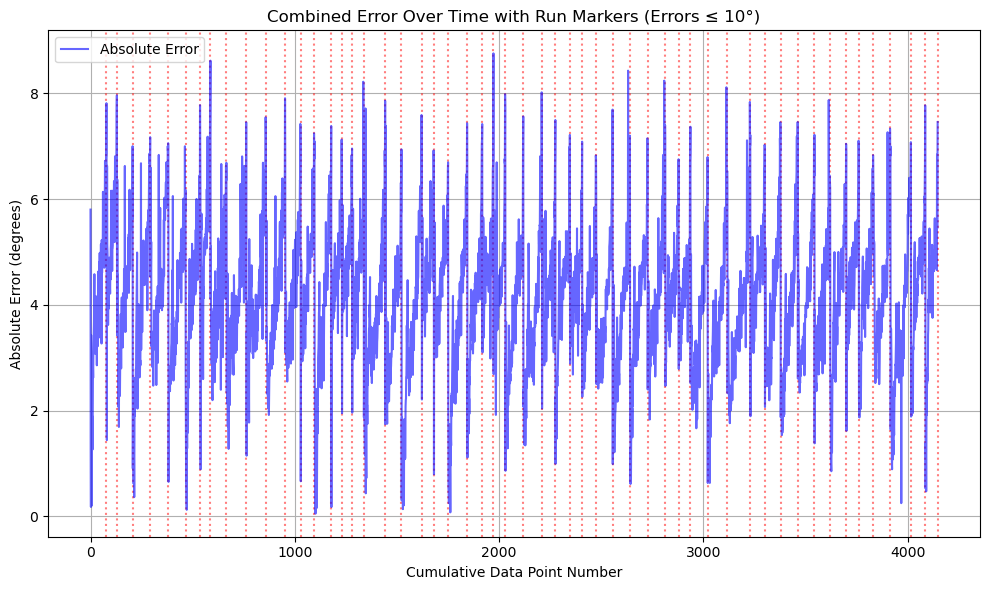

In [12]:
# Create new figure for error plot
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Combine all error data into one continuous series
all_errors = []
all_indices = []
current_index = 0

for run in range(1, 55):
    error_col = f'err_{run}'
    if error_col in df.columns:
        # Get non-null values only
        valid_data = df[df[error_col].notna()]
        if not valid_data.empty:
            # Add errors to combined list, excluding errors > 10
            errors = [e for e in valid_data[error_col].tolist() if e <= 10]
            if errors:  # Only process if we have valid errors
                all_errors.extend(errors)
                
                # Create continuous indices
                indices = range(current_index, current_index + len(errors))
                all_indices.extend(indices)
                
                # Update current index
                current_index += len(errors)
                
                # Add vertical line at the end of each run
                ax.axvline(x=current_index-1, color='red', linestyle=':', alpha=0.5)

# Plot combined data
ax.plot(all_indices, all_errors, color='blue', alpha=0.6, label='Absolute Error')

ax.set_xlabel('Cumulative Data Point Number')
ax.set_ylabel('Absolute Error (degrees)')
ax.set_title('Combined Error Over Time with Run Markers (Errors ≤ 10°)')
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()